In [1]:
!export PYTHONPATH=/usr/project/xtmp/sk787/variable_imp_matching/

In [2]:
import sys
sys.path.append('/usr/project/xtmp/sk787/variable_imp_matching/')
sys.path.insert(0, '/usr/project/xtmp/sk787/variable_imp_matching/')

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsRegressor
# from datagen.dgp_df import dgp_poly_basic_df, dgp_df
from src.variable_imp_matching import VIM
from scipy.spatial.distance import pdist
import warnings
from utils import save_df_to_csv
from collections import namedtuple
from argparse import ArgumentParser
from econml.dml import CausalForestDML, KernelDML
from econml.dr import DRLearner
from econml.metalearners import XLearner, TLearner, SLearner
from sklearn.ensemble import GradientBoostingRegressor

import numpy as np
from econml.metalearners import XLearner, TLearner, SLearner
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

from tqdm import tqdm

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


In [3]:
import numpy as np
# from datagen.dgp_df import dgp_df
from variance_playground import *
from src.variable_imp_matching import VIM

In [229]:
from sklearn.preprocessing import StandardScaler, minmax_scale
def linear_outcome(X, T):
    n_samples = X.shape[0]
    coef = np.array(list(range(2)) + [0] * (X.shape[1] - 2))
    Y0_true = X.dot(coef).reshape(-1,1)
    Y1_true = Y0_true + 1 + X.dot(coef).reshape(-1,1)
    error = np.random.uniform(-1, 1, size = (n_samples, 1))
    Y1 = Y1_true + error
    Y0 = Y0_true + error
    Y = (Y1 * T) + Y0 * (1 - T)
    TE = Y1_true - Y0_true
    return X, Y, T, Y0, Y1, TE, Y0_true, Y1_true

def dgp_linear(n_unimp, n_samples):
    n_imp = 2
    xmin = 0
    xmax = 5
    X = np.random.uniform(xmin, xmax, size = [n_samples, n_imp + n_unimp])
    T = np.random.binomial(n = 1, p = minmax_scale(X[:,0] + 3 * X[:, 1], feature_range=(0.25, 0.75))).reshape(-1,1)
    coef = np.array(list(range(n_imp)) + [0] * n_unimp)
    Y0_true = X.dot(coef).reshape(-1,1)
    Y1_true = 2 * Y0_true + 1
    error = np.random.uniform(-1, 1, size = (n_samples, 1))
    Y1 = Y1_true + error
    Y0 = Y0_true + error
    Y = (Y1 * T) + Y0 * (1 - T)
    TE = Y1_true - Y0_true
    # min is just smallest y0 == min(y0_true) - 1 == 0 - 1 = -1
    ymin = np.array([xmin] * (n_imp + n_unimp)).dot(coef) - 1 # substract error as well
    # max is largest y1 == max(y1_true) + error == max(2 * y0_true + 1) + error = 2 * max(y0_true) + 1 + 1
    ymax = 2 * np.array([xmax] * (n_imp + n_unimp)).dot(coef) + 2 # add error as well
    return X, Y, T, Y0, Y1, TE, Y0_true, Y1_true, ymin, ymax

def dgp_lihua(n_unimp, n_samples, corr, heteroskedasticity):
    n_imp = 2
    mean = np.array([0] * (n_imp + n_unimp))
    cov = np.ones(shape = [n_imp + n_unimp, n_imp + n_unimp]) * corr
    np.fill_diagonal(cov, np.repeat(a = 1, repeats=n_imp + n_unimp))
    X = np.random.multivariate_normal(mean, cov, size = n_samples)
    xmax = 5
    xmin = -5
    X[X > xmax] = xmax
    X[X < xmin] = xmin
    
    import scipy.stats as stats
    T = np.random.binomial(n = 1, p = stats.beta.cdf(x = X[:, 0], a = 2, b = 4)).reshape(-1,1)
    def f(X): # bounded by [0,2]
        return 2/(1 + np.exp(-12 * (X - 0.5)))
    Y0_true = (np.array([0] * n_samples)).reshape(-1,1)
    Y1_true = (f(X[:, 0]) * f(X[:, 1])).reshape(-1,1)
    max_error = 1
    min_error = -1
    error = np.random.uniform(min_error, max_error, size = (n_samples, 1)) # bounded by [-1,1]

    if heteroskedasticity:
        error = error * np.log(X[:, 0]**2 + 1).reshape(-1,1)
        max_error = max_error * np.log(np.max(np.abs([xmax, xmin]))**2 + 1)
        min_error = min_error * np.log(np.min(np.abs([xmax, xmin]))**2 + 1)
    
    Y1 = Y1_true + error
    Y0 = Y0_true + error
    
    Y = (Y1 * T) + Y0 * (1 - T)
    TE = Y1_true - Y0_true

    # ymax = max(y1_true + error) = max(y1_true) + max(error) = max(f(\cdot)) * max(f(\cdot)) + max(error) = 2 * 2 + max(error) 
    ymax = 4 + max_error
    # ymin = min(y1_true + error, y0_true + error) = min(sigmoid(\cdot) + error, 0 + error) = min(0 + error, 0 + error) = min(error)
    ymin = min_error

    return X, Y, T, Y0, Y1, TE, Y0_true, Y1_true, ymin, ymax


def dgp_df(dgp, n_samples, n_imp = None, n_unimp=None, perc_train=None, n_train=None, X = None, data_seed = 42, coef_seed = 42):
    """Create sine or exponential dataframe."""
    if dgp == 'sine':
        X, Y, T, Y0, Y1, TE, Y0_true, Y1_true = dgp_sine(n_samples, n_unimp)
        discrete = []
    if dgp == 'exp':
        X, Y, T, Y0, Y1, TE, Y0_true, Y1_true = dgp_exp(n_samples, n_unimp)
        discrete = []
    if dgp == 'nonlinear_mml':
        X, Y, T, Y0, Y1, TE, Y0_true, Y1_true = dgp_nonlinear_mml(n_samples, n_unimp, data_seed = data_seed, coef_seed = coef_seed)
        discrete = []
    if dgp == 'piecewise_mml':
        X, Y, T, Y0, Y1, TE, Y0_true, Y1_true = dgp_piecewise_mml(n_samples, n_unimp, data_seed = data_seed, coef_seed = coef_seed)
        discrete = []
    if dgp == 'poly':
        if n_imp is None:
            n_imp = 20
        return *dgp_poly_basic_df(n_samples, n_imp = n_imp, n_unimp = n_unimp, powers=[2], perc_train=perc_train,
                      n_train=n_train), []
    if dgp == 'linear':
        if n_imp is None:
            n_imp = 20
        X, Y, T, Y0, Y1, TE, Y0_true, Y1_true, ymin, ymax = dgp_linear(n_samples = n_samples, n_unimp = n_unimp)
        discrete = []
    if dgp == 'lihua_uncorr_homo':
        X, Y, T, Y0, Y1, TE, Y0_true, Y1_true, ymin, ymax = dgp_lihua(n_unimp = n_unimp, n_samples = n_samples, corr = 0, heteroskedasticity = False)
        discrete = []
    if dgp == 'lihua_corr_homo':
        X, Y, T, Y0, Y1, TE, Y0_true, Y1_true, ymin, ymax = dgp_lihua(n_unimp = n_unimp, n_samples = n_samples, corr = 0.9, heteroskedasticity = False)
        discrete = []
    if dgp == 'lihua_uncorr_hetero':
        X, Y, T, Y0, Y1, TE, Y0_true, Y1_true, ymin, ymax = dgp_lihua(n_unimp = n_unimp, n_samples = n_samples, corr = 0, heteroskedasticity = True)
        discrete = []
    if dgp == 'lihua_corr_hetero':
        X, Y, T, Y0, Y1, TE, Y0_true, Y1_true, ymin, ymax = dgp_lihua(n_unimp = n_unimp, n_samples = n_samples, corr = 0.9, heteroskedasticity = True)
        discrete = []
    if perc_train:
        train_idx = int(n_samples*perc_train)
    else:
        train_idx = n_train
    df = pd.DataFrame(np.concatenate([X, Y, T, Y0, Y1, TE, Y0_true, Y1_true],
                                     axis=1))
    x_cols = [f'X{i}' for i in range(X.shape[1])]
    df.columns = [*x_cols, 'Y', 'T', 'Y0', 'Y1', 'TE', 'Y0_true', 'Y1_true']

    df[x_cols] = StandardScaler().fit_transform(df[x_cols])
    df['T'] = df['T'].astype(int)

    df_train = df.copy(deep=True).loc[:train_idx, ]
    df_train = df_train.drop(columns=['Y0', 'Y1', 'TE', 'Y0_true', 'Y1_true'])
    df_true = df.copy(deep=True).loc[train_idx:, ]
    df_assess = df_true.copy(deep=True).drop(
        columns=['Y0', 'Y1', 'TE', 'Y0_true', 'Y1_true'])
    return df_train.reset_index(drop=True), df_assess.reset_index(drop=True), \
           df_true.reset_index(drop=True), x_cols, discrete, ymin, ymax



In [230]:
from confseq.betting import hedged_cs, betting_ci

def normalize_samples(samples, min, max):
    return (samples - min)/(max - min)

def unnormalize_samples(samples, min, max):
    return samples * (max - min) + min

def make_betting_ci(samples, alpha, min, max):
    y_min = samples.min()
    y_max = samples.max() 
    
    samples_normalized = normalize_samples(samples, min, max) # (samples - y_min)/(y_max - y_min)

    # print('normalized min, max:', samples_normalized.min(), samples_normalized.max())

    betting_cs_result = betting_ci(samples_normalized, alpha = alpha)
    betting_lb = betting_cs_result[0]
    betting_ub = betting_cs_result[1]

    betting_lb = unnormalize_samples(betting_lb, min, max) # betting_lb * (y_max - y_min) + y_min
    betting_ub = unnormalize_samples(betting_ub, min, max) # betting_ub * (y_max - y_min) + y_min
    
    return betting_lb, betting_ub

def get_betting_bounds(df_est, Y, tx, mgs, T, C, alpha, ymin, ymax):
    # def make_betting_ci(samples, alpha, y_min, y_max):
        
    #     samples_normalized = (samples - y_min)/(y_max - y_min)

    #     betting_cs_result = betting_ci(samples_normalized, alpha = alpha)
    #     betting_lb = betting_cs_result[0]
    #     betting_ub = betting_cs_result[1]

    #     betting_lb = betting_lb * (y_max - y_min) + y_min
    #     betting_ub = betting_ub * (y_max - y_min) + y_min
        
    #     return betting_lb, betting_ub

    # df_est[Y] = (df_est[Y].values  - df_est[Y].min())/(df_est[Y].max() - df_est[Y].min())
    df_est[Y + '_normalized'] = df_est[Y].values * (df_est[tx].values) - df_est[Y].values * (1 - df_est[tx].values)
    # y_max = df_est[Y + '_normalized'].max()
    # y_min = df_est[Y + '_normalized'].min()
    # df_est[Y + '_normalized'] = (df_est[Y + '_normalized'].values  - y_min)/(y_max - y_min)
    Y_T = df_est[Y + '_normalized'].values[mgs[T]]
    Y_C = df_est[Y + '_normalized'].values[mgs[C]] 
    Y_stack = np.hstack([Y_T, Y_C])
    # get confidence intervals from hedging by betting sequences...
    # lb = np.apply_along_axis(arr = Y_stack, func1d = lambda x: hedged_cs(x, alpha=alpha)[0][-1], axis = 1)
    # ub = np.apply_along_axis(arr = Y_stack, func1d = lambda x: hedged_cs(x, alpha=alpha)[1][-1], axis = 1)

    y_min = -np.max(np.abs([ymin, ymax]))
    y_max = np.max(np.abs([ymin, ymax]))

    print('y_min', y_min)
    print('y_max', y_max)

    lb = np.apply_along_axis(arr = Y_stack, func1d = lambda x: make_betting_ci(x, alpha=alpha, min = y_min, max = y_max)[0], axis = 1)
    ub = np.apply_along_axis(arr = Y_stack, func1d = lambda x: make_betting_ci(x, alpha=alpha, min = y_min, max = y_max)[1], axis = 1)

    ## un-normalize the bounds
    # lb = lb * (y_max - y_min) + y_min
    # ub = ub * (y_max - y_min) + y_min
    return lb, ub
    
def get_CATE_bias_betting_bound(X_NN_T, X_NN_C, query_x, k, model_dict, T, C, df_est, Y, tx, mgs, ymin, ymax, alpha = 0.05):
    T_uq = []
    C_uq = []
    for i in range(k):
        T_uq.append(model_dict[T].predict(X_NN_T[i], T = 1))
        C_uq.append(model_dict[C].predict(X_NN_C[i], T = 0))

    T_uq = np.array(T_uq).mean(axis = 0)
    T_query = model_dict[T].predict(query_x, T = 1)
    # T_uq = np.abs(T_query - T_uq)
    print('T_uq shape:', T_uq.shape)

    C_uq = np.array(C_uq).mean(axis = 0)
    C_query = model_dict[C].predict(query_x, T = 0)
    # C_uq = np.abs(C_query - C_uq)
    print('C_uq shape:', C_uq.shape)

    bias = np.abs(T_uq - T_query - C_uq + T_query)

    lb, ub = get_betting_bounds(df_est = df_est, Y = Y, tx = tx, mgs = mgs, T = T, C = C, alpha = alpha, ymin = ymin, ymax = ymax)
    lb, ub = lb - bias, ub + bias
    
    return lb, ub

In [234]:
seed = 42

dgp = 'lihua_corr_hetero'
n_train = 10000
n_est = 1000
n_imp = 2
n_unimp = 10
k = int(np.sqrt(n_est))

np.random.seed(100)
df_train, query_x, df_true, x_cols, discrete, ymin, ymax = dgp_df(dgp = dgp, n_samples = 100, n_imp = n_imp, n_unimp=n_unimp, perc_train=None, n_train=0)
query_x['CATE_true'] = df_true['TE']

np.random.seed(42)

# make dataset
df_train, df_est, df_true, x_cols, discrete, ymin, ymax = dgp_df(dgp = dgp, n_samples = n_train + n_est, n_imp = n_imp, n_unimp=n_unimp, perc_train=None, n_train=n_train)
 ## split into train, calibrate, and estimation
df_train_sub, df_calib = train_test_split(df_train, test_size = 0.0001, stratify = df_train['T'].values, random_state = 42)


# fit LCM to find distance metric
lcm = VIM(outcome = 'Y', treatment = 'T', data = df_train_sub, binary_outcome=False, random_state=None)
lcm.fit(return_scores = False, model = 'ensemble')
# lcm.M = np.array(list(range(n_imp)) + [0] * n_unimp)
coverage = []

for seed in range(10):
    print(seed, end = '\r')
    seed *= 42
    # sample Ys on estiamtion set for this seed
    np.random.seed(seed)
    df_est['Y'] = df_true['Y1_true'] * df_true['T'] + df_true['Y0_true'] * (1 - df_true['T']) + np.random.uniform(-1, 1, df_est.shape[0])

    # estimate CATEs
    mgs, mgs_dists = lcm.create_mgs(df_estimation=df_est, k=k, return_original_idx=False, query_x = query_x)
    cate = lcm.est_cate(df_est, match_groups = mgs, match_distances = mgs_dists, k = k, diameter_prune = False, query_x = query_x)
    cate['CATE_true'] = query_x['CATE_true']

    # estimate confidence intervals for query set
    class dgp_model:
        def __init__(self, dgp):
            self.dgp = dgp
        
        def fit(self, X_train, y_train):
            return None
        
        def predict(self, X_est, T):
            if type(X_est) != np.ndarray:
                X_est = np.array(X_est)
            if self.dgp == 'linear':
                n_imp = 2
                n_unimp = X_est.shape[1] - n_imp
                coef = np.array(list(range(n_imp)) + [0] * n_unimp)
                Y0_true = X_est.dot(coef)
                Y1_true = Y0_true + 1 + X_est.dot(coef)
            elif 'lihua' in self.dgp:
                def f(X): # bounded by [0,2]
                    return 2/(1 + np.exp(-12 * (X - 0.5)))
                Y0_true = 0
                Y1_true = f(X_est[:, 0]) * f(X_est[:, 1])
            return Y1_true * T + Y0_true * (1 - T)

    model_dict = calib_bias(df = df_calib, treatment = 'T', outcome = 'Y', sklearn_model = dgp_model, T = 1, C = 0, args = {'dgp' : dgp})

    X_NN_T = {j : df_est.loc[mgs[1][j].values].drop(['T', 'Y'], axis = 1) for j in range(k)}
    X_NN_C = {j : df_est.loc[mgs[0][j].values].drop(['T', 'Y'], axis = 1) for j in range(k)}

    lb, ub = get_CATE_bias_betting_bound(X_NN_T = X_NN_T, X_NN_C = X_NN_C, query_x = query_x.drop(['T', 'Y'], axis = 1), k = k, model_dict = model_dict, T = 1, C = 0, df_est = df_est, Y = 'Y', tx = 'T', mgs = mgs, alpha = 0.05, ymin = ymin, ymax = ymax)
    cate['CATE_lb'] = lb
    cate['CATE_ub'] = ub
    cate['CATE_error_bound'] = np.abs(cate['CATE_ub'] - cate['CATE_lb'])/2
    cate['contains_true_cate'] = (cate['CATE_lb'] <= cate['CATE_true']) * (cate['CATE_ub'] >= cate['CATE_true'])
    cate['seed'] = seed
    cate['id'] = cate.index.values
    
    # evaluate coverage
    coverage.append(cate)

291: query_x is None: False
T_uq shape: (100,)
C_uq shape: (100,)
y_min -7.258096538021482
y_max 7.258096538021482
291: query_x is None: False
T_uq shape: (100,)
C_uq shape: (100,)
y_min -7.258096538021482
y_max 7.258096538021482
291: query_x is None: False
T_uq shape: (100,)
C_uq shape: (100,)
y_min -7.258096538021482
y_max 7.258096538021482
291: query_x is None: False
T_uq shape: (100,)
C_uq shape: (100,)
y_min -7.258096538021482
y_max 7.258096538021482
291: query_x is None: False
T_uq shape: (100,)
C_uq shape: (100,)
y_min -7.258096538021482
y_max 7.258096538021482
291: query_x is None: False
T_uq shape: (100,)
C_uq shape: (100,)
y_min -7.258096538021482
y_max 7.258096538021482
291: query_x is None: False
T_uq shape: (100,)
C_uq shape: (100,)
y_min -7.258096538021482
y_max 7.258096538021482
291: query_x is None: False
T_uq shape: (100,)
C_uq shape: (100,)
y_min -7.258096538021482
y_max 7.258096538021482
291: query_x is None: False
T_uq shape: (100,)
C_uq shape: (100,)
y_min -7.25809

In [200]:
ymin

array([-0.99992083])

In [197]:
df_train, df_est, df_true, x_cols, discrete, ymin, ymax = dgp_df(dgp = dgp, n_samples = n_train + n_est, n_imp = n_imp, n_unimp=n_unimp, perc_train=None, n_train=n_train)
df_est

,X0,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,X11,Y,T
0,0.608347,-0.523391,1.427549,1.399849,1.053364,0.072912,0.029622,-0.571138,-0.746460,-0.997809,-1.511307,1.406201,-0.555438,1
1,0.627623,-0.810519,0.151724,-0.138726,-0.915786,0.035733,0.695875,-1.204820,-0.747776,1.201706,-0.951456,0.249148,-0.952172,1
2,0.492707,0.800388,0.406171,-1.138400,0.722530,-2.231859,0.766595,-0.522443,-0.489519,1.169099,-1.117577,0.112182,2.720405,1
3,0.456933,-0.753035,-0.312899,-0.677303,0.276084,0.455722,-1.898884,1.453905,1.575641,0.540937,-1.359958,-1.431150,0.559773,1
4,-1.759789,0.302753,1.337137,1.378197,-0.094238,-0.744562,0.569741,1.137557,1.224022,0.299629,-0.686033,0.722723,0.795105,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,-0.747482,0.876658,-1.519443,-0.528043,0.545916,-0.868039,0.523732,0.597451,0.141607,-0.846585,-0.520471,-0.971674,-0.844266,0
996,0.666006,0.113893,-0.102111,-0.037975,0.154629,-0.776710,0.515918,-1.537056,0.726921,0.080148,1.024200,-0.255413,-0.025852,1
997,0.064894,-0.023096,1.512989,0.604136,0.678443,0.568487,-0.011288,0.518954,0.890447,0.610787,0.200152,0.070706,0.578243,0
998,0.733121,2.924332,-0.116232,-0.583400,-0.195181,0.713816,1.559779,0.159107,-0.177290,0.762362,-0.528665,0.556663,4.677037,1


In [236]:
print('CATE coverage:', cate['contains_true_cate'].mean())
print('CATE interval length:', cate['CATE_error_bound'].mean())

CATE coverage: 0.98
CATE interval length: 1.8797513933277512


<AxesSubplot:>

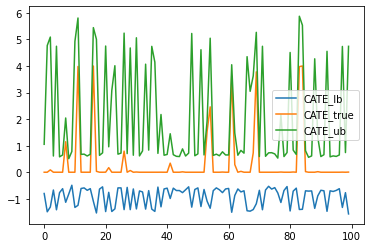

In [205]:
cate[['CATE_lb', 'CATE_true', 'CATE_ub']].plot()

In [9]:
coverage_df = pd.concat(coverage)
# coverage_agg[coverage_agg < 0.95]

In [21]:
coverage_df.groupby('id').mean().reset_index(drop = True).head(10)

,Y0_mean,Y1_mean,CATE_mean,dist_0,dist_1,CATE_true,CATE_lb,CATE_ub,CATE_error_bound,contains_true_cate,seed
0,0.297880,1.597166,1.299286,0.071581,0.161548,1.278369,0.565640,1.433271,0.433815,1.0,189.0
1,0.158307,1.276867,1.118560,0.069902,0.157163,1.108377,0.343874,1.255107,0.455616,0.9,189.0
2,0.386333,1.821958,1.435624,0.089965,0.110323,1.372832,0.385205,1.927630,0.771212,1.0,189.0
3,0.099405,1.144417,1.045012,0.066564,0.172584,1.059942,0.029823,1.424598,0.697388,1.0,189.0
4,0.878727,2.761780,1.883052,0.093931,0.102729,1.852395,-0.580457,4.528446,2.554452,1.0,189.0
5,0.641270,2.248173,1.606903,0.139861,0.100840,1.592805,-0.042755,3.033216,1.537985,1.0,189.0
6,0.975092,2.960514,1.985422,0.365550,0.161162,1.966610,-0.717232,5.102533,2.909883,1.0,189.0
7,0.357641,1.786062,1.428422,0.069198,0.156428,1.335596,0.493624,1.767995,0.637186,1.0,189.0
8,0.709472,2.348210,1.638737,0.153092,0.117057,1.641101,-0.128541,3.292439,1.710490,1.0,189.0
9,0.206289,1.327852,1.121563,0.081342,0.131731,1.166694,0.542696,1.107924,0.282614,0.3,189.0


In [24]:
coverage_df.query('id == 9').head(10)#[['CATE_ub', 'CATE_true']].plot()

,Y0_mean,Y1_mean,CATE_mean,dist_0,dist_1,CATE_true,CATE_lb,CATE_ub,CATE_error_bound,contains_true_cate,seed,id
9,0.365122,1.211045,0.845923,0.081342,0.131731,1.166694,0.461650,0.979786,0.259068,False,0,9
9,0.336166,1.343646,1.007481,0.081342,0.131731,1.166694,0.566182,1.069845,0.251831,False,42,9
9,0.144306,1.498750,1.354444,0.081342,0.131731,1.166694,0.672745,1.223946,0.275601,True,84,9
9,0.241843,1.432777,1.190934,0.081342,0.131731,1.166694,0.629827,1.149214,0.259693,False,126,9
9,0.114460,1.378780,1.264320,0.081342,0.131731,1.166694,0.585842,1.177282,0.295720,True,168,9
9,0.152917,1.201372,1.048455,0.081342,0.131731,1.166694,0.430064,1.064167,0.317052,False,210,9
9,0.261677,1.309944,1.048268,0.081342,0.131731,1.166694,0.521546,1.073035,0.275744,False,252,9
9,0.101880,1.380813,1.278933,0.081342,0.131731,1.166694,0.590856,1.168622,0.288883,True,294,9
9,0.282397,1.437908,1.155511,0.081342,0.131731,1.166694,0.625628,1.135876,0.255124,False,336,9
9,0.062122,1.083488,1.021367,0.081342,0.131731,1.166694,0.342624,1.037465,0.347421,False,378,9


In [25]:
coverage_df['contains_true_cate'].mean()

0.888

1. Coverage with "true" distance metric: 88.8%

In [34]:
df_est_copy = df_est.copy()

df_est_copy['Y1_true'] = dgp_model(dgp = 'linear').predict(X_est = df_est_copy, T = 1)
df_est_copy['Y0_true'] = -1 * dgp_model(dgp = 'linear').predict(X_est = df_est_copy, T = 0)

In [47]:
query_x['true_mgs_mean'] = np.hstack([df_est_copy['Y1_true'].values[mgs[1]], df_est_copy['Y0_true'].values[mgs[1]]]).mean(axis = 1)

In [52]:
query_x['id'] = query_x.index

coverage_df.merge(query_x[['id', 'true_mgs_mean']], on = 'id', how = 'inner')

,Y0_mean,Y1_mean,CATE_mean,dist_0,dist_1,CATE_true,CATE_lb,CATE_ub,CATE_error_bound,contains_true_cate,seed,id,true_mgs_mean
0,0.380976,1.634855,1.253879,0.071581,0.161548,1.278369,0.607145,1.417433,0.405144,True,0,0,0.152052
1,0.244188,1.711583,1.467395,0.071581,0.161548,1.278369,0.679648,1.522179,0.421265,True,42,0,0.152052
2,0.175147,1.674535,1.499389,0.071581,0.161548,1.278369,0.608530,1.526229,0.458849,True,84,0,0.152052
3,0.413141,1.541405,1.128264,0.071581,0.161548,1.278369,0.521640,1.361759,0.420059,True,126,0,0.152052
4,0.223004,1.679641,1.456637,0.071581,0.161548,1.278369,0.647495,1.518346,0.435426,True,168,0,0.152052
...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,0.063142,1.286448,1.223306,0.087607,0.146966,1.176668,0.541193,1.093725,0.276266,False,210,99,-0.031152
996,0.299296,1.245085,0.945789,0.087607,0.146966,1.176668,0.509671,0.979569,0.234949,False,252,99,-0.031152
997,0.110216,1.400540,1.290325,0.087607,0.146966,1.176668,0.654916,1.133583,0.239333,False,294,99,-0.031152
998,0.345800,1.494932,1.149132,0.087607,0.146966,1.176668,0.713204,1.100923,0.193860,False,336,99,-0.031152


In [51]:
coverage_df

,Y0_mean,Y1_mean,CATE_mean,dist_0,dist_1,CATE_true,CATE_lb,CATE_ub,CATE_error_bound,contains_true_cate,seed,id
0,0.380976,1.634855,1.253879,0.071581,0.161548,1.278369,0.607145,1.417433,0.405144,True,0,0
1,0.199022,1.142043,0.943021,0.069902,0.157163,1.108377,0.241988,1.170579,0.464296,True,0,1
2,0.350612,2.023171,1.672559,0.089965,0.110323,1.372832,0.559593,2.105864,0.773135,True,0,2
3,0.097639,0.986847,0.889208,0.066564,0.172584,1.059942,-0.093131,1.344036,0.718583,True,0,3
4,1.027822,2.709982,1.682160,0.093931,0.102729,1.852395,-0.621413,4.493570,2.557491,True,0,4
...,...,...,...,...,...,...,...,...,...,...,...,...
95,0.940880,2.815981,1.875100,0.102332,0.095120,1.857291,-0.546298,4.601885,2.574092,True,378,95
96,0.405585,2.258391,1.852806,0.087636,0.126024,1.511863,0.253480,2.778438,1.262479,True,378,96
97,0.360573,1.939880,1.579307,0.118153,0.097602,1.445997,0.240871,2.255948,1.007539,True,378,97
98,0.300394,1.610831,1.310438,0.065297,0.183496,1.238626,0.690984,1.328898,0.318957,True,378,98


### Check if ramdas actually covers the mean

In [7]:
from confseq.betting import betting_ci, hedged_cs
import numpy as np
import pandas as pd
true_mean = 5
coverage_betting = []
coverage_betting_est = []
coverage_hedged = []

betting_lb_list = []
betting_ub_list = []

betting_est_lb_list = []
betting_est_ub_list = []

hedged_lb_list = []
hedged_ub_list = []

def normalize_samples(samples, min, max):
    return (samples - min)/(max - min)

def unnormalize_samples(samples, min, max):
    return samples * (max - min) + min

def make_betting_ci(samples, alpha, min, max):
    y_min = samples.min()
    y_max = samples.max() 
    
    samples_normalized = normalize_samples(samples, min, max) # (samples - y_min)/(y_max - y_min)

    betting_cs_result = betting_ci(samples_normalized, alpha = alpha)
    betting_lb = betting_cs_result[0]
    betting_ub = betting_cs_result[1]

    betting_lb = unnormalize_samples(betting_lb, min, max) # betting_lb * (y_max - y_min) + y_min
    betting_ub = unnormalize_samples(betting_ub, min, max) # betting_ub * (y_max - y_min) + y_min
    
    return betting_lb, betting_ub

def make_hedged_ci(samples, alpha, min, max):
    y_min = samples.min()
    y_max = samples.max()

    samples_normalized = normalize_samples(samples, min, max)

    hedged_cs_result = hedged_cs(samples_normalized, alpha = alpha)

    hedged_lb = hedged_cs_result[0][-1]
    hedged_ub = hedged_cs_result[1][-1]
    hedged_lb = unnormalize_samples(hedged_lb, min, max) #hedged_lb * (y_max - y_min) + y_min
    hedged_ub = unnormalize_samples(hedged_ub, min, max) #hedged_ub * (y_max - y_min) + y_min
    
    return hedged_lb, hedged_ub


for seed in range(500):
    seed *= 42
    np.random.seed(seed)
    samples_a = np.random.uniform(true_mean - 10, true_mean, size = 10)
    samples_b = np.random.uniform(true_mean - 5, true_mean + 5, size = 10)
    samples_c = np.random.uniform(true_mean, true_mean + 10, size = 10)
    samples = np.concatenate([samples_a, samples_b, samples_c])
    
    betting_est_lb, betting_est_ub = make_betting_ci(samples, alpha = 0.05, min = samples.min(), max = samples.max())
    betting_est_lb_list.append(betting_est_lb)
    betting_est_ub_list.append(betting_est_ub)
    coverage_betting_est.append((betting_est_lb <= true_mean) * (true_mean <= betting_est_ub))

    

    betting_lb, betting_ub = make_betting_ci(samples, alpha = 0.05, min = true_mean - 10, max = true_mean + 10)
    betting_lb_list.append(betting_lb)
    betting_ub_list.append(betting_ub)
    coverage_betting.append((betting_lb <= true_mean) * (true_mean <= betting_ub))

    # hedged_lb, hedged_ub = make_hedged_ci(samples, alpha = 0.05, min = true_mean - 10, max = true_mean + 10)
    # hedged_lb_list.append(hedged_lb)
    # hedged_ub_list.append(hedged_ub)
    # coverage_hedged.append((hedged_lb <= true_mean) * (true_mean <= hedged_ub))

In [8]:
print('Hedged coverage:', np.mean(coverage_betting_est))
print('Betting coverage:', np.mean(coverage_betting))

Hedged coverage: 0.976
Betting coverage: 0.998


<AxesSubplot:>

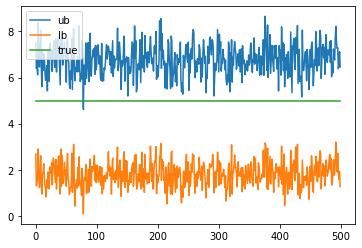

In [6]:
pd.DataFrame({'ub' : betting_ub_list, 'lb' : betting_lb_list, 'true' : true_mean}).plot()